
Dataset Overview:
          filename major_category class_name  \
0  1-34094-A-5.wav        animals        cat   
1  1-34094-B-5.wav        animals        cat   
2  1-47819-A-5.wav        animals        cat   
3  1-47819-B-5.wav        animals        cat   
4  1-47819-C-5.wav        animals        cat   

                                           file_path  
0  X:\Projects\ML\Project\esc_50\animals\cat\1-34...  
1  X:\Projects\ML\Project\esc_50\animals\cat\1-34...  
2  X:\Projects\ML\Project\esc_50\animals\cat\1-47...  
3  X:\Projects\ML\Project\esc_50\animals\cat\1-47...  
4  X:\Projects\ML\Project\esc_50\animals\cat\1-47...  

Total number of recordings: 2000
Unique major categories: 5
Unique classes: 50

Plotting Class Distribution:


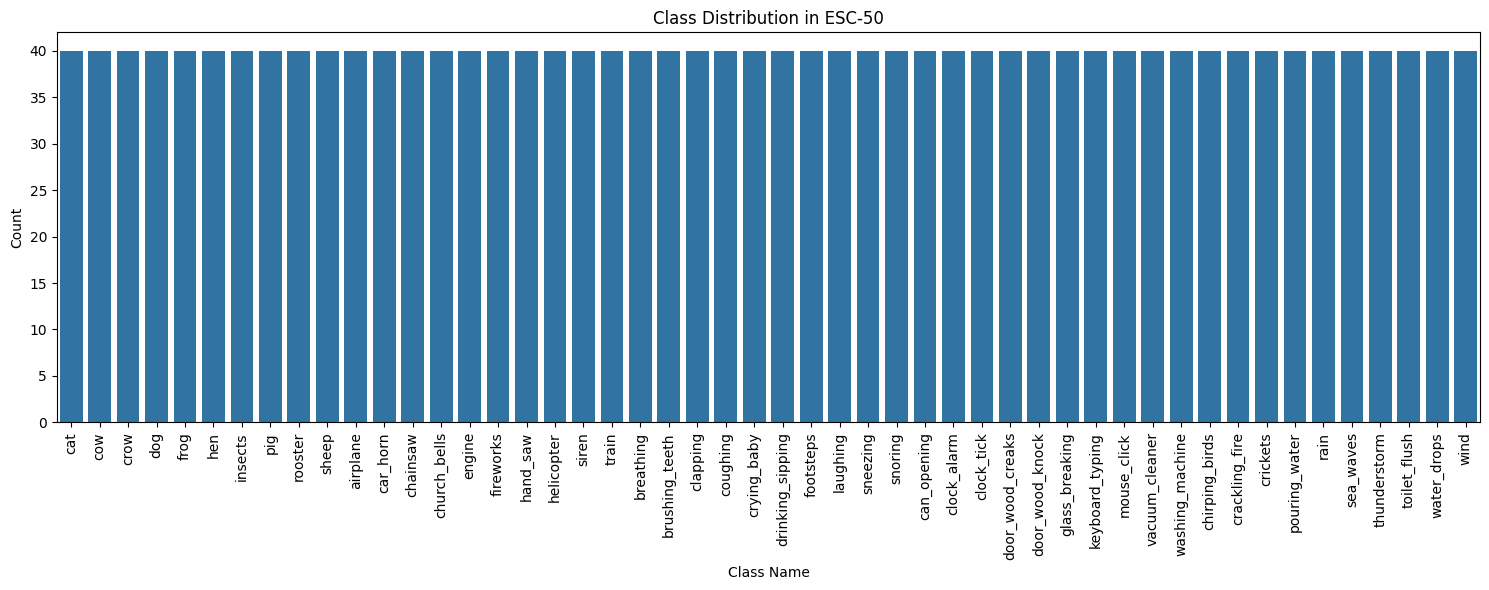


Plotting Major Category Distribution:


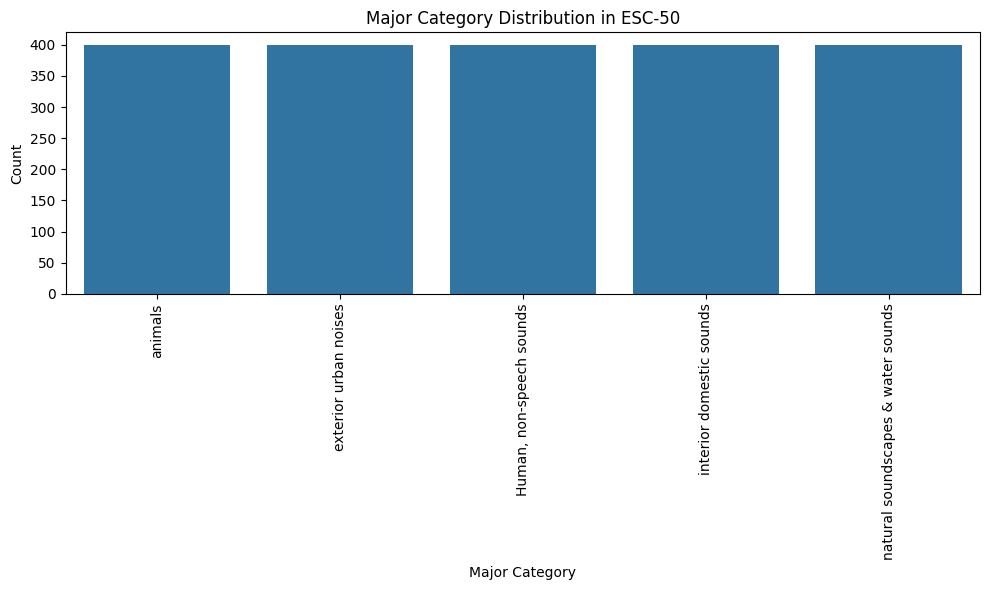

Displaying Audio Waveforms And Spectrogram Of Random Audios:


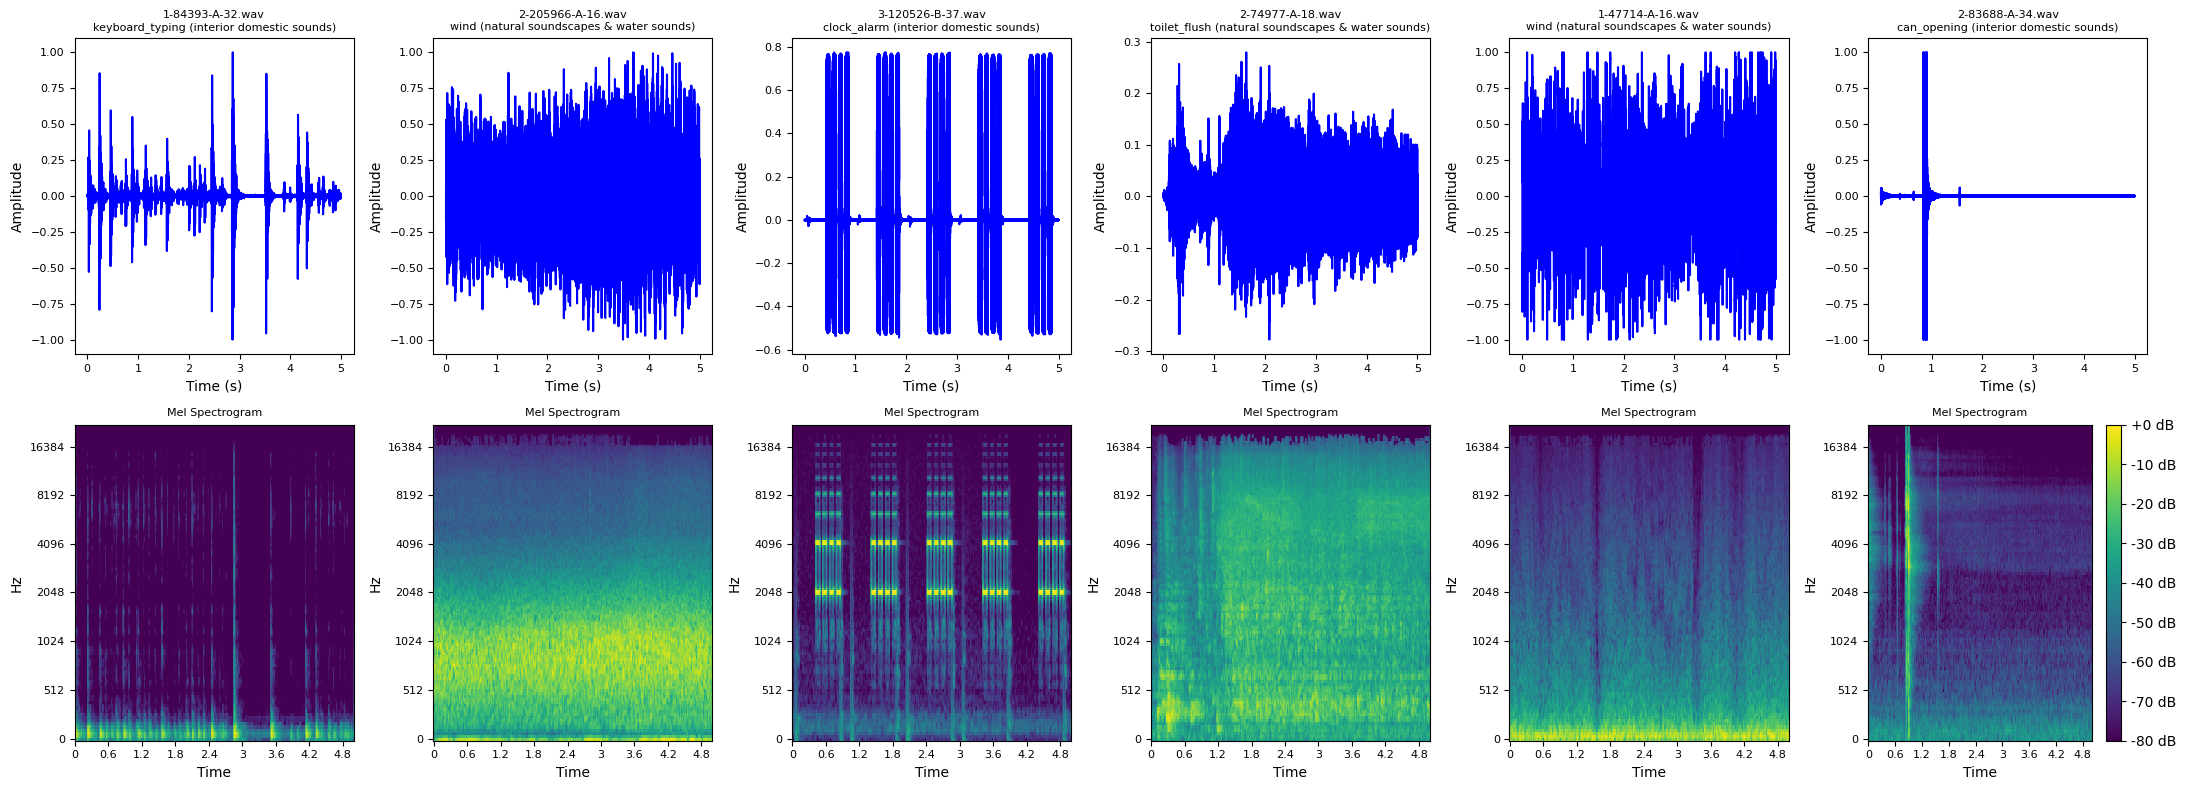


Training Samples: 1600
 - Labeled Samples: 160
 - Unlabeled Samples: 1440
Validation Samples: 199
Test Samples: 201

Displaying Augmented Audios with Generated Waveforms for SpecAugment and Cutout:


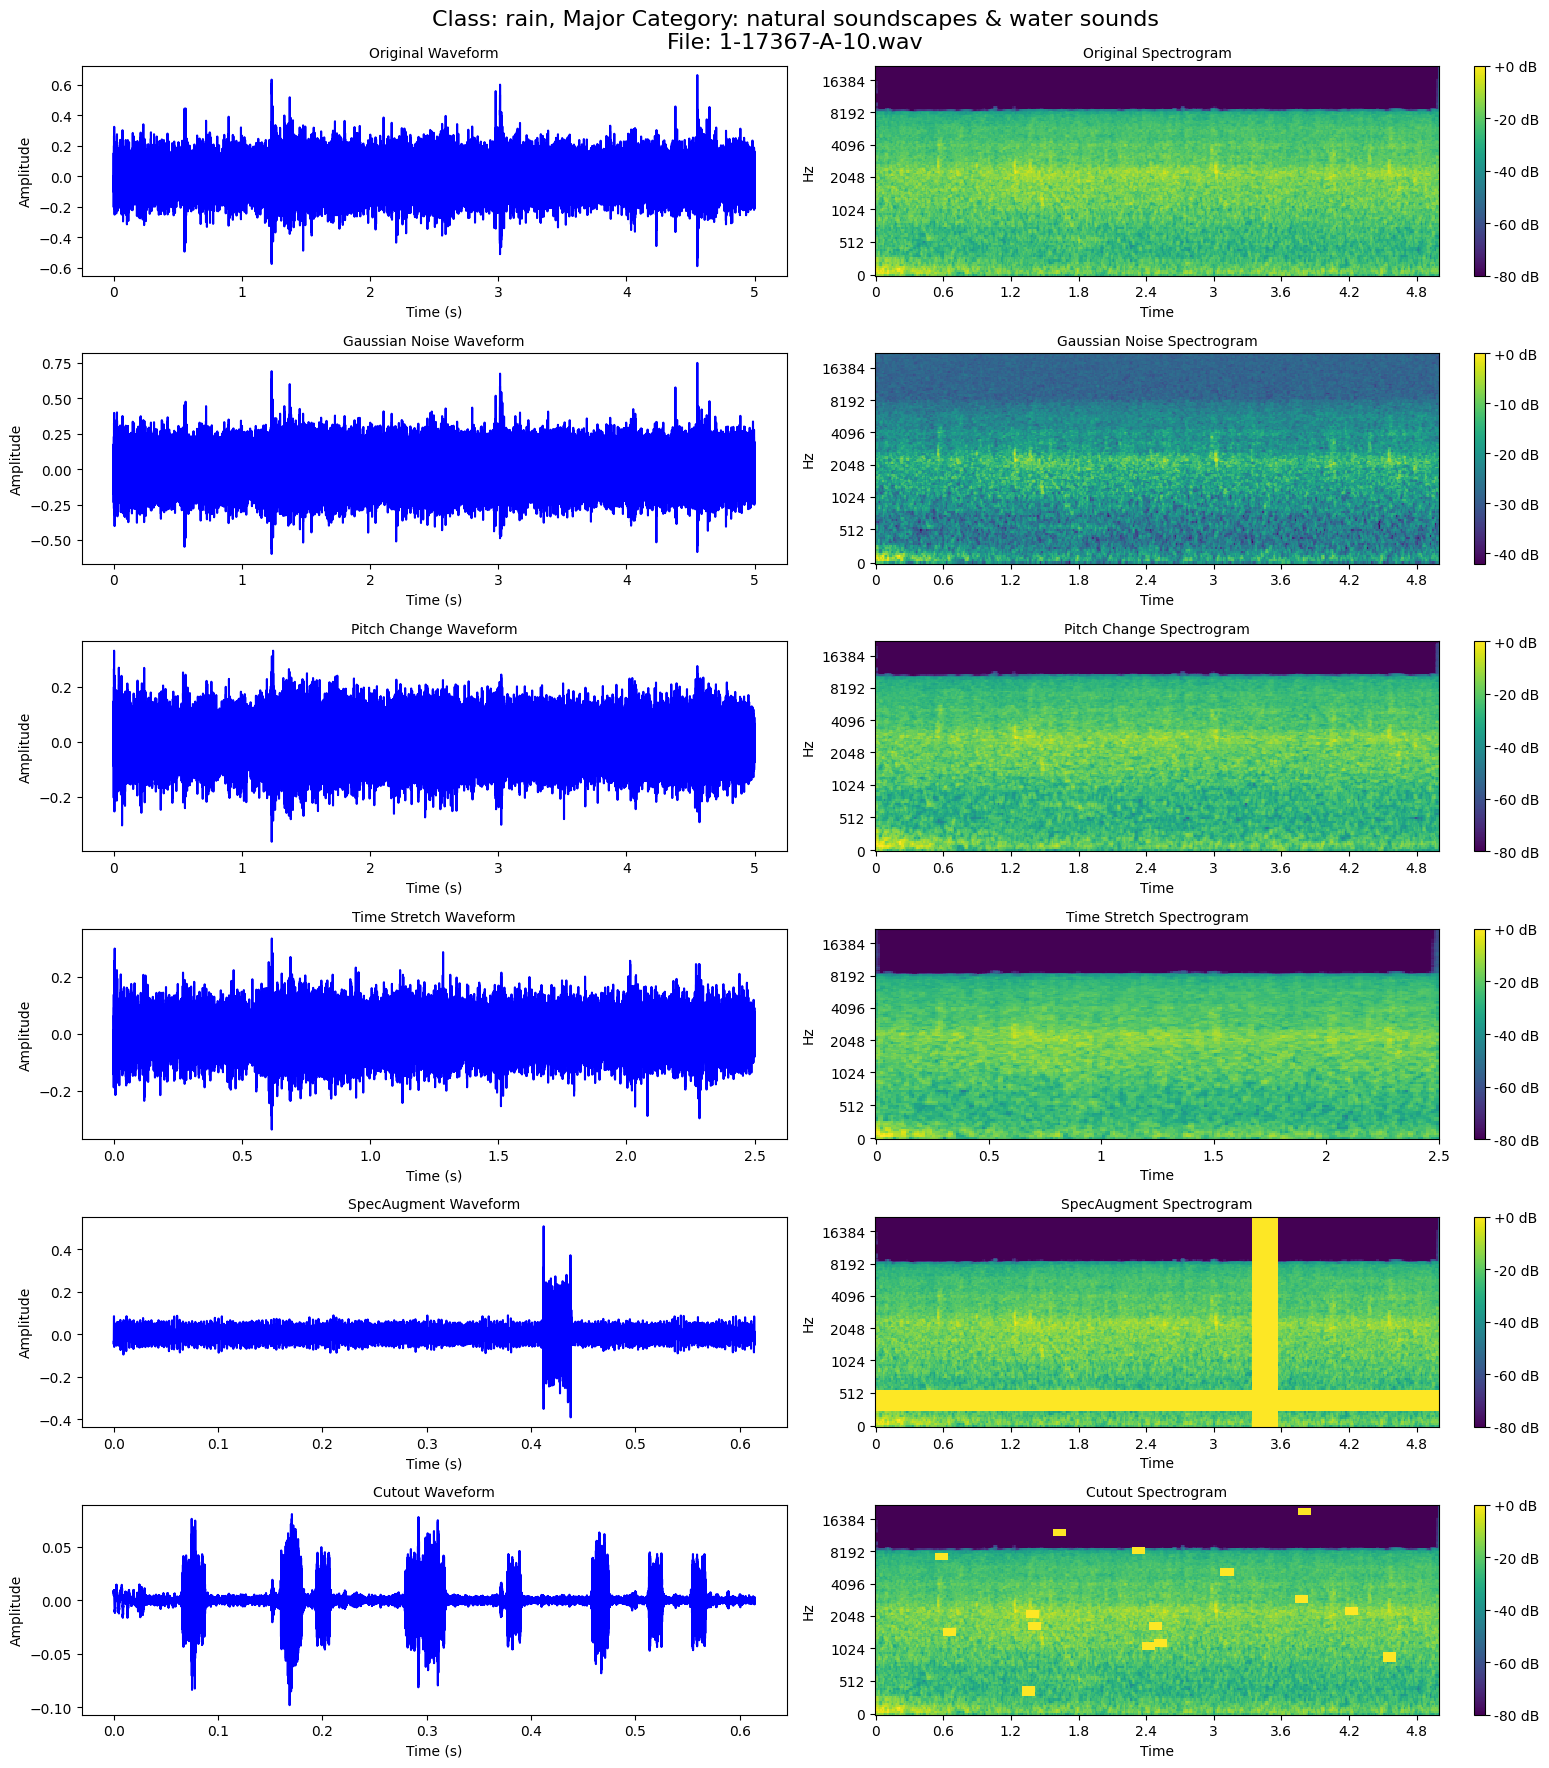

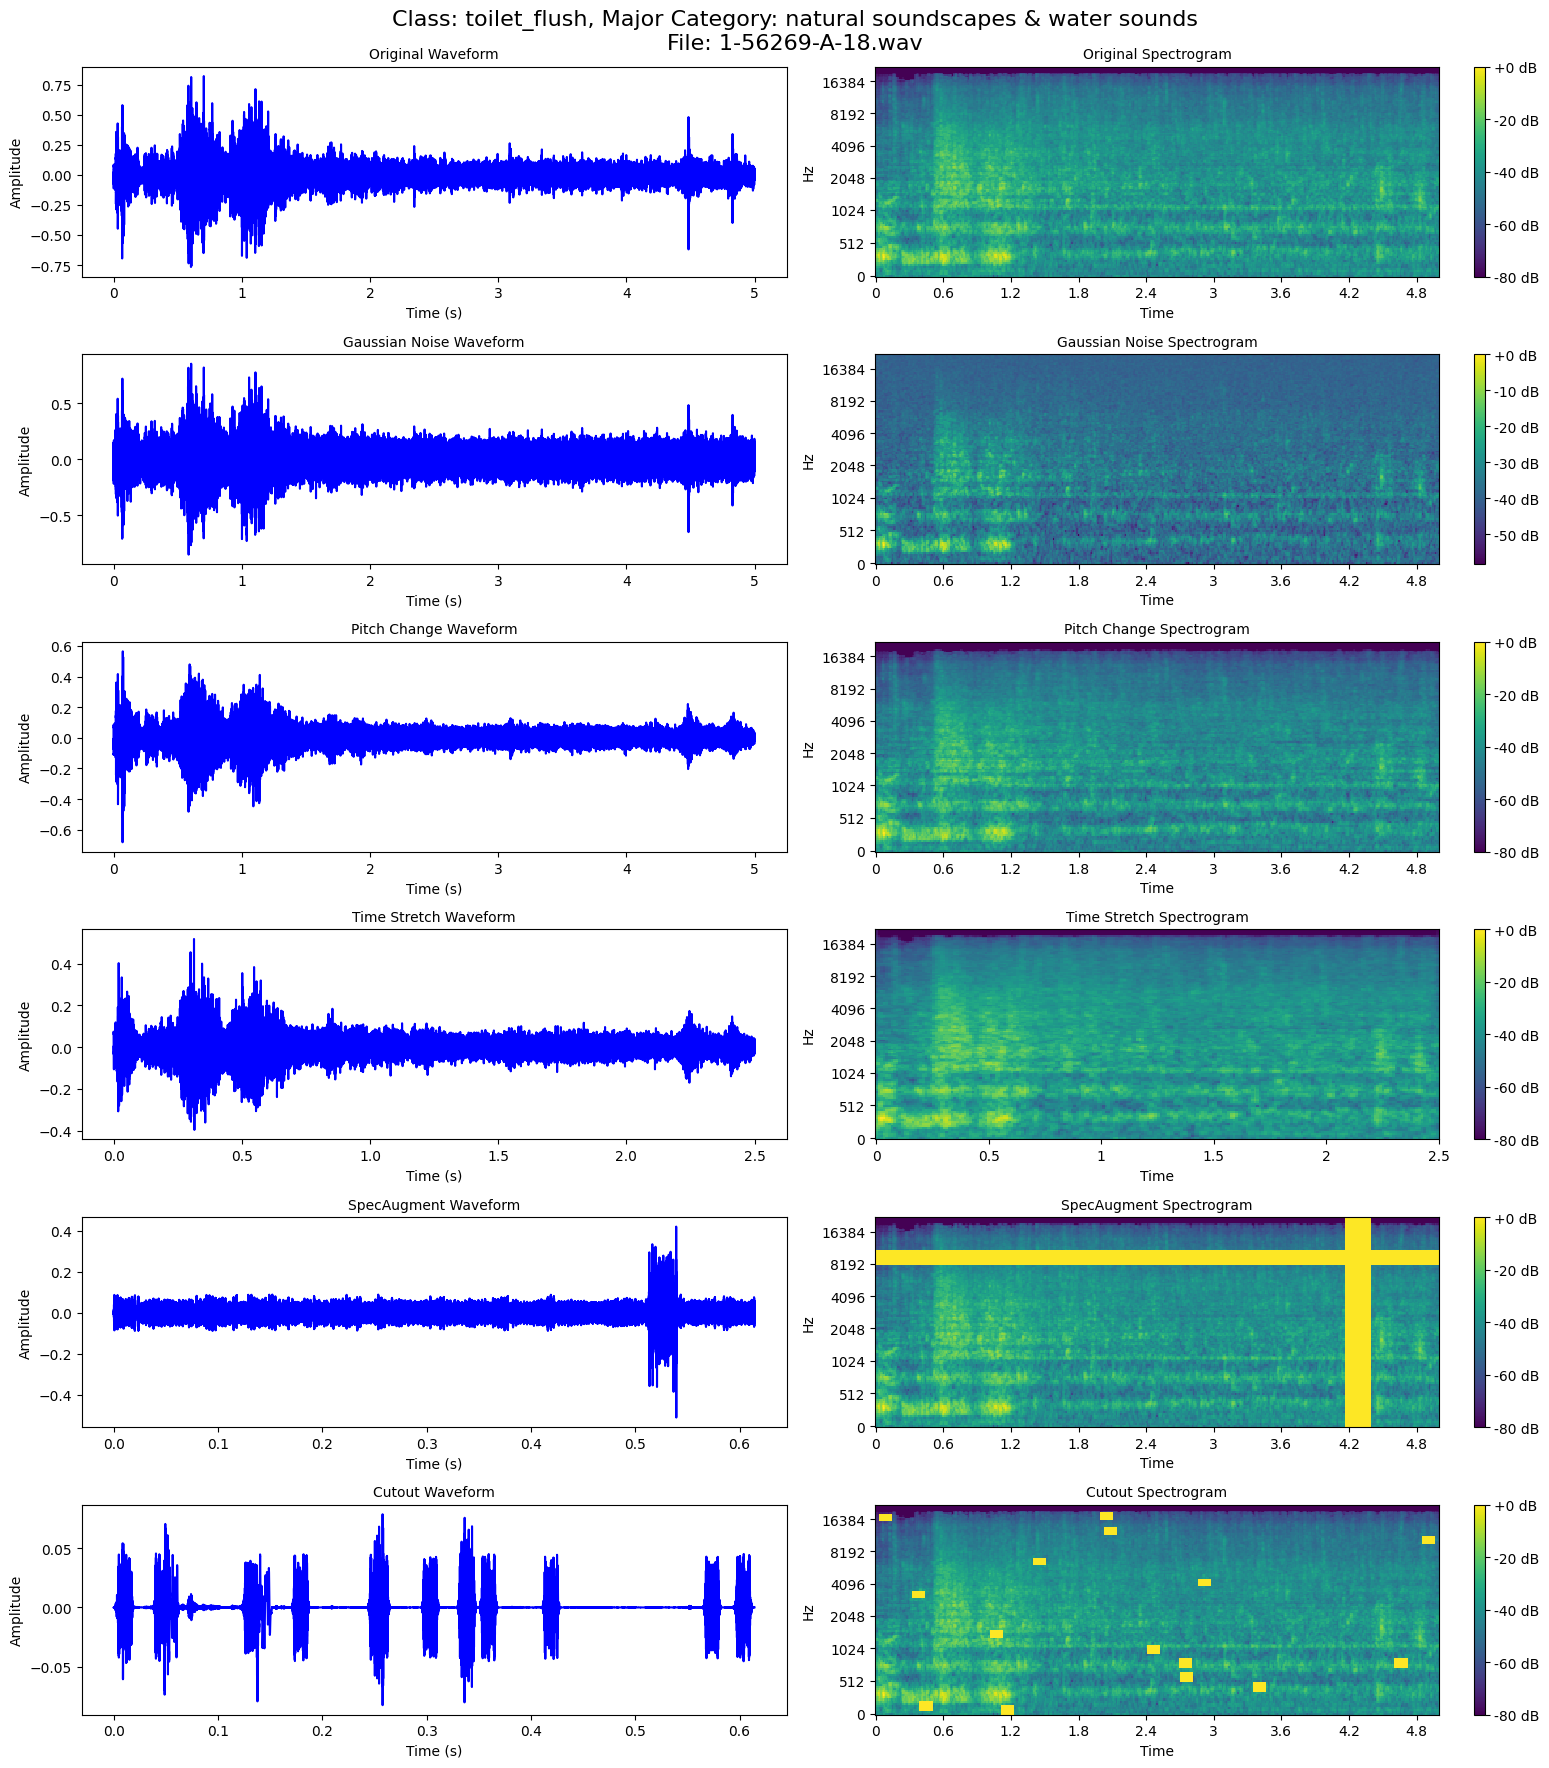

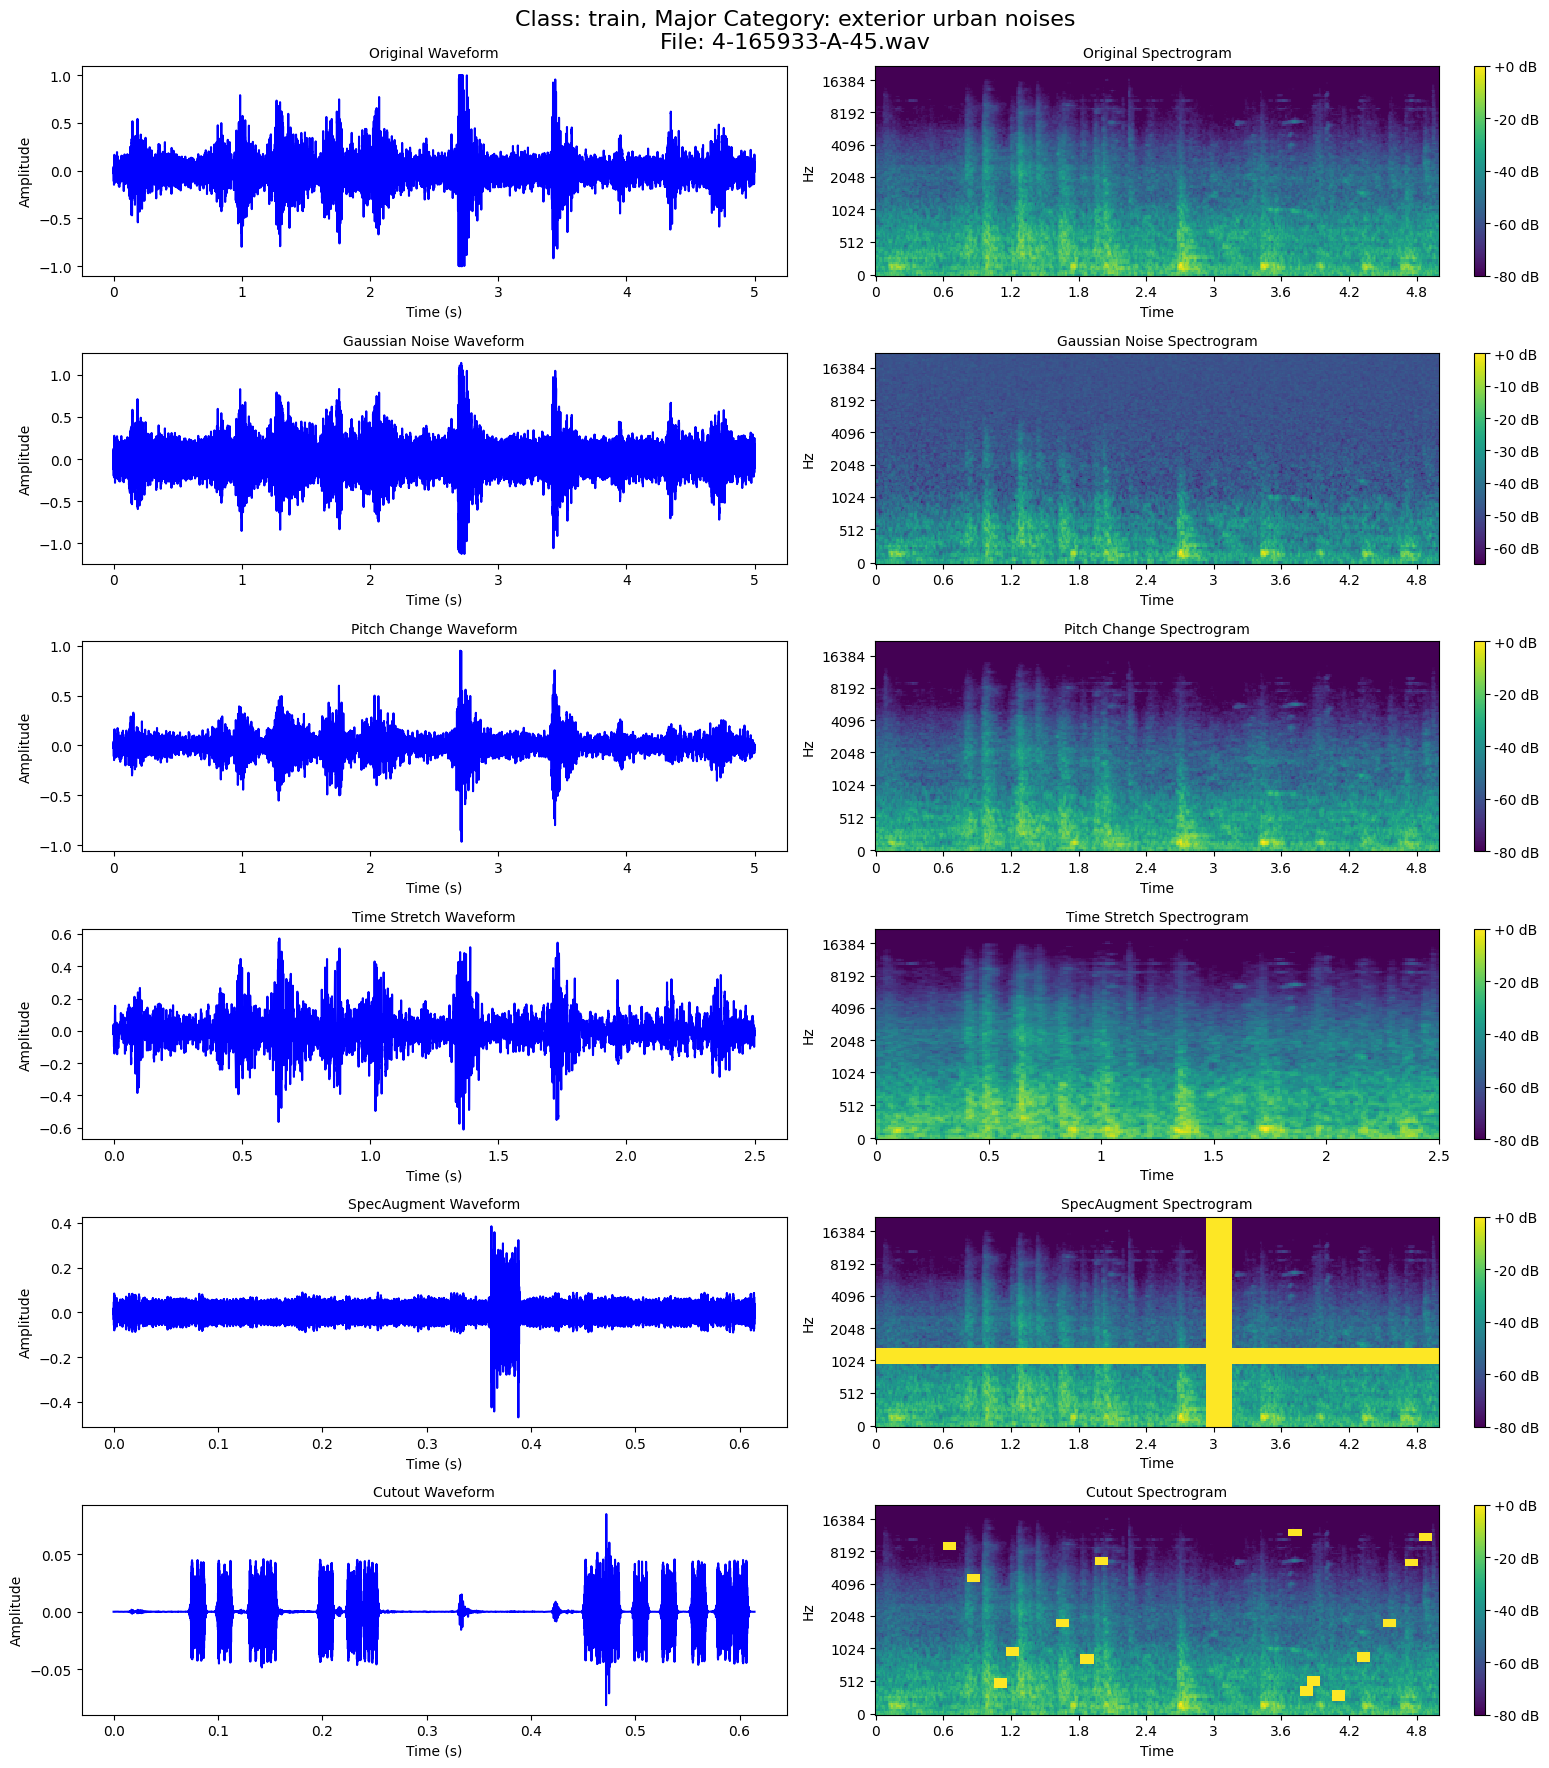


Audio Augmentations being applied:
Gaussian Noise, Pitch Change, Time Stretch, SpecAugment, Cutout


In [2]:
import os
import librosa, librosa.display
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.model_selection import train_test_split

RANDOM_STATE = 2022484
np.random.seed(RANDOM_STATE)
DATA_DIR = r"X:\Projects\ML\Project\esc_50"

def load_meta_from_directory(data_dir):
    meta_data = []
    for major_category in os.listdir(data_dir):
        major_path = os.path.join(data_dir, major_category)
        if os.path.isdir(major_path):
            for class_name in os.listdir(major_path):
                class_path = os.path.join(major_path, class_name)
                if os.path.isdir(class_path):
                    for file_name in os.listdir(class_path):
                        if file_name.endswith(".wav"):
                            meta_data.append({
                                "filename": file_name,
                                "major_category": major_category,
                                "class_name": class_name,
                                "file_path": os.path.join(class_path, file_name)
                            })
    return pd.DataFrame(meta_data)

meta = load_meta_from_directory(DATA_DIR)
print("\nDataset Overview:")
print(meta.head())
print(f"\nTotal number of recordings: {len(meta)}")
print(f"Unique major categories: {meta['major_category'].nunique()}")
print(f"Unique classes: {meta['class_name'].nunique()}")

def plot_class_distribution(meta):
    plt.figure(figsize=(15, 6))
    sns.countplot(data=meta, x="class_name", order=meta["class_name"].value_counts().index)
    plt.title("Class Distribution in ESC-50")
    plt.xticks(rotation=90)
    plt.xlabel("Class Name")
    plt.ylabel("Count")
    plt.tight_layout()
    plt.show()

print("\nPlotting Class Distribution:")
plot_class_distribution(meta)

def plot_major_category_distribution(meta):
    plt.figure(figsize=(10, 6))
    sns.countplot(data=meta, x="major_category")
    plt.title("Major Category Distribution in ESC-50")
    plt.xticks(rotation=90)
    plt.xlabel("Major Category")
    plt.ylabel("Count")
    plt.tight_layout()
    plt.show()
print("\nPlotting Major Category Distribution:")
plot_major_category_distribution(meta)

def display_random_audios(meta, num_samples=6):
    random_files = meta.sample(num_samples)
    fig, axes = plt.subplots(2, num_samples, figsize=(22, 8))
    
    for i, (idx, row) in enumerate(random_files.iterrows()):
        file_path = row["file_path"]
        file_name = row["filename"]
        class_name = row["class_name"]
        major_category = row["major_category"]

        signal, sr = librosa.load(file_path, sr=None)
        mel_spec = librosa.feature.melspectrogram(y=signal, sr=sr, n_fft=2048, hop_length=512, n_mels=128)
        mel_spec_db = librosa.power_to_db(mel_spec, ref=np.max)

        axes[0, i].plot(np.linspace(0, len(signal) / sr, len(signal)), signal, color="b")
        axes[0, i].set_title(f"{file_name}\n{class_name} ({major_category})", fontsize=8)
        axes[0, i].set_xlabel("Time (s)")
        axes[0, i].set_ylabel("Amplitude")
        axes[0, i].tick_params(axis="x", labelsize=8)
        axes[0, i].tick_params(axis="y", labelsize=8)

        img = librosa.display.specshow(mel_spec_db, sr=sr, hop_length=512, x_axis="time", y_axis="mel", cmap="viridis", ax=axes[1, i])
        axes[1, i].set_title(f"Mel Spectrogram", fontsize=8)
        axes[1, i].tick_params(axis="x", labelsize=8)
        axes[1, i].tick_params(axis="y", labelsize=8)
        if i == num_samples - 1:
            fig.colorbar(img, ax=axes[1, i], format="%+2.0f dB")

    plt.tight_layout()
    plt.show()
print("Displaying Audio Waveforms And Spectrogram Of Random Audios:")
display_random_audios(meta, num_samples=6)

def train_val_test(meta, train_size=0.8, val_test_size=0.1, labeled_ratio=0.1):
    train_meta, temp_meta = train_test_split(meta, test_size=1 - train_size, stratify=meta["class_name"], random_state=RANDOM_STATE)
    val_meta, test_meta = train_test_split(temp_meta, test_size=val_test_size / (1 - train_size), stratify=temp_meta["class_name"], random_state=RANDOM_STATE)
    train_labeled_meta, train_unlabeled_meta = train_test_split(train_meta, test_size=1 - labeled_ratio, stratify=train_meta["class_name"], random_state=RANDOM_STATE)

    print(f"\nTraining Samples: {len(train_meta)}")
    print(f" - Labeled Samples: {len(train_labeled_meta)}")
    print(f" - Unlabeled Samples: {len(train_unlabeled_meta)}")
    print(f"Validation Samples: {len(val_meta)}")
    print(f"Test Samples: {len(test_meta)}")

    return train_labeled_meta, train_unlabeled_meta, val_meta, test_meta
train_labeled_meta, train_unlabeled_meta, val_meta, test_meta = train_val_test(meta)

def add_gaussian_noise(signal, sr, noise_factor=0.05):
    noise = np.random.normal(0, 1, len(signal))
    return signal + noise_factor * noise

def time_stretch(signal, sr, stretch_rate=2):
    return librosa.effects.time_stretch(signal, rate=stretch_rate)

def spec_augment(mel_spec):
    time_mask_param = 20
    freq_mask_param = 10
    mel_spec_aug = mel_spec.copy()
    time_start = np.random.randint(0, mel_spec.shape[1] - time_mask_param)
    mel_spec_aug[:, time_start:time_start + time_mask_param] = 0
    freq_start = np.random.randint(0, mel_spec.shape[0] - freq_mask_param)
    mel_spec_aug[freq_start:freq_start + freq_mask_param, :] = 0
    return mel_spec_aug

def cutout(mel_spec, num_holes=15, hole_size=(5, 10)):
    mel_spec_aug = mel_spec.copy()
    for _ in range(num_holes):
        x = np.random.randint(0, mel_spec.shape[1] - hole_size[1])
        y = np.random.randint(0, mel_spec.shape[0] - hole_size[0])
        mel_spec_aug[y:y + hole_size[0], x:x + hole_size[1]] = 0
    return mel_spec_aug

def pitch_change(signal, sr, pitch_range=5):
    pitch_steps = np.random.uniform(-pitch_range, pitch_range)
    return librosa.effects.pitch_shift(y=signal, sr=sr, n_steps=pitch_steps)

def display_augmented(meta, num_samples=3):
    random_files = meta.sample(num_samples)
    for idx, row in random_files.iterrows():
        file_path = row["file_path"]
        file_name = row["filename"]
        class_name = row["class_name"]
        major_category = row["major_category"]

        signal, sr = librosa.load(file_path, sr=None)
        mel_spec = librosa.feature.melspectrogram(y=signal, sr=sr, n_fft=2048, hop_length=512, n_mels=128)
        mel_spec_db = librosa.power_to_db(mel_spec, ref=np.max)

        augmented_signals = {"Gaussian Noise": add_gaussian_noise(signal, sr), "Pitch Change": pitch_change(signal, sr), "Time Stretch": time_stretch(signal, sr),}
        augmented_spectrograms = {"SpecAugment": spec_augment(mel_spec_db), "Cutout": cutout(mel_spec_db)}

        fig, axes = plt.subplots(6, 2, figsize=(16, 18))
        axes[0, 0].plot(np.linspace(0, len(signal) / sr, len(signal)), signal, color="b")
        axes[0, 0].set_title("Original Waveform", fontsize=10)
        axes[0, 0].set_xlabel("Time (s)")
        axes[0, 0].set_ylabel("Amplitude")

        librosa.display.specshow(mel_spec_db, sr=sr, hop_length=512, x_axis="time", y_axis="mel", cmap="viridis", ax=axes[0, 1])
        axes[0, 1].set_title("Original Spectrogram", fontsize=10)
        fig.colorbar(librosa.display.specshow(mel_spec_db, sr=sr, hop_length=512, x_axis="time", y_axis="mel", cmap="viridis"), ax=axes[0, 1], format="%+2.0f dB")

        for i, (aug_name, aug_signal) in enumerate(augmented_signals.items(), start=1):
            mel_spec_aug = librosa.feature.melspectrogram(y=aug_signal, sr=sr, n_fft=2048, hop_length=512, n_mels=128)
            mel_spec_db_aug = librosa.power_to_db(mel_spec_aug, ref=np.max)

            axes[i, 0].plot(np.linspace(0, len(aug_signal) / sr, len(aug_signal)), aug_signal, color="b")
            axes[i, 0].set_title(f"{aug_name} Waveform", fontsize=10)
            axes[i, 0].set_xlabel("Time (s)")
            axes[i, 0].set_ylabel("Amplitude")

            librosa.display.specshow(mel_spec_db_aug, sr=sr, hop_length=512, x_axis="time", y_axis="mel", cmap="viridis", ax=axes[i, 1])
            axes[i, 1].set_title(f"{aug_name} Spectrogram", fontsize=10)
            fig.colorbar(librosa.display.specshow(mel_spec_db_aug, sr=sr, hop_length=512, x_axis="time", y_axis="mel", cmap="viridis"), ax=axes[i, 1], format="%+2.0f dB")

        for i, (aug_name, aug_spec) in enumerate(augmented_spectrograms.items(), start=4):
            wave_from_spec = librosa.griffinlim(librosa.db_to_power(aug_spec))
            axes[i, 0].plot(np.linspace(0, len(wave_from_spec) / sr, len(wave_from_spec)), wave_from_spec, color="b")
            axes[i, 0].set_title(f"{aug_name} Waveform", fontsize=10)
            axes[i, 0].set_xlabel("Time (s)")
            axes[i, 0].set_ylabel("Amplitude")

            librosa.display.specshow(aug_spec, sr=sr, hop_length=512, x_axis="time", y_axis="mel", cmap="viridis", ax=axes[i, 1])
            axes[i, 1].set_title(f"{aug_name} Spectrogram", fontsize=10)
            fig.colorbar(librosa.display.specshow(aug_spec, sr=sr, hop_length=512, x_axis="time", y_axis="mel", cmap="viridis"), ax=axes[i, 1], format="%+2.0f dB")

        plt.suptitle(f"Class: {class_name}, Major Category: {major_category}\nFile: {file_name}", fontsize=16)
        plt.tight_layout()
        plt.show()

print("\nDisplaying Augmented Audios with Generated Waveforms for SpecAugment and Cutout:")
display_augmented(meta, num_samples=3)

print("\nAudio Augmentations being applied:")
augmentations = ["Gaussian Noise", "Pitch Change", "Time Stretch", "SpecAugment", "Cutout"]
print(", ".join(augmentations))